In [1]:
import requests
import json
import os
import urllib.request
import matplotlib.pyplot as plt
import re
import csv
from datetime import date, datetime
from requests.exceptions import HTTPError, Timeout

In [2]:
# Receives a datetime object, converts it into age
def get_age(birthday):
    today = date.today()
    age_s = today.year - birthday.year
    if today.month < birthday.month:
        age_s -= 1
    elif today.month == birthday.month and today.day < birthday.day:
        age_s -= 1
    return age_s


# Sets up a csv file
def reformat_csv(status, post_id, poster_id, first_name, last_name,
                 sex, city, bdate, age, education, text):
    length = len(text)
    string = '%s,%s,%s,%s,%s,%s,%s,%s,%s,"%s",%s,"%s"' % (
        status, post_id, poster_id, first_name, last_name,
        sex, city, bdate, age, education, length, text)
    return string


# Appends lines to a csv file
def make_csv(line):
    string = 'status,post_id,owner_id,name,surname,sex,city,' \
             'bdate,age,education,length,text,comments_id\n'
    if not os.path.exists('stats.csv'):
        with open('stats.csv', 'w', encoding='utf-8') as f:
            f.write(string)
    with open('stats.csv', 'a', encoding='utf-8') as f:
        f.write(line)

In [3]:
def get_poster_info(poster_id, token):
    if poster_id < 0:
        (first_name, last_name, sex,
         city, bdate, age, education) = None, None, None, None, None, None, None
        return (first_name, last_name, sex,
                city, bdate, age, education)
    endpoint = 'api.vk.com/method'
    params = {'access_token': token, 'v': '5.95', 'user_id': poster_id,
              'fields': 'city,sex,first_name,last_name,bdate,education'}
    try:
        req = requests.get('https://api.vk.com/method/users.get',
                           params=params)
        data = req.text
        req.raise_for_status()
    except HTTPError or Timeout:
        print('Could not get User Info')
        return None
    else:
        data = json.loads(data)
        try:
            items = data['response'][0]
        except KeyError:
            return None
        else:
            first_name = items['first_name']  # poster/commenter name
            last_name = items['last_name']  # poster/commenter surname
            sex = items['sex']
            # specifies the user's sex
            if sex == 1:
                sex = 'female'
            elif sex == 2:
                sex = 'male'
            else:
                sex = 'unspecified'
            # tries to get the name of the city
            try:
                city = items['city']['title']
            except KeyError:
                city = None
            # gets the user's age if possible
            try:
                bdate = items['bdate']
            except KeyError:
                bdate = None
                age = None
            else:
                try:
                    day, month, year = bdate.split('.')
                except ValueError:
                    age = None
                else:
                    time_string = day + '/' + month + '/' + year
                    birthday = datetime.strptime(time_string, '%d/%m/%Y')
                    age = get_age(birthday)
            # tries to get one of the degrees if given
            try:
                education = items['university_name']
            except KeyError:
                education = None
    return first_name, last_name, sex, city, bdate, age, education

In [4]:
# Gets comments for post, returns info about the commenter
def get_comment_info(post_id, community_id, token):
    # while True, try to get the post's comments
    comments = []
    strings = []
    offset = 0
    while True:
        if offset:
            params = {'access_token': token, 'v': '5.95',
                      'owner_id': community_id, 'post_id': post_id,
                      'count': 100, 'offset': offset}
        else:
            params = {'access_token': token, 'v': '5.95',
                      'owner_id': community_id, 'post_id': post_id,
                      'count': 100}  # all parameters
        try:
            req = requests.get('https://api.vk.com/method/wall.getComments',
                               params=params)
            data = req.text
            req.raise_for_status()  # as usual, we try to mine stuff
        except HTTPError or Timeout:
            print('Could not mine wall for data')
        else:
            status = 'comment'
            data = json.loads(data)
            items = data['response']['items']
            if not items:  # if no comments, returns blank list
                break
            offset += 100
            for item in items:
                try:
                    text = item['text']
                except KeyError:
                    text = None
                comment_id = item['id']
                try:
                    poster_id = item['from_id']
                except KeyError:
                    pass
                else:
                    # gets info on the commenter
                    (first_name, last_name, sex, city, bdate,
                     age, education) = get_poster_info(poster_id, token)
                    comments.append(comment_id)  # gets list of comments
                    # makes a string ready for csv input
                    string = reformat_csv(status, post_id, poster_id,
                                          first_name, last_name, sex,
                                          city, bdate, age, education, text)
                    string += ',' + str(comment_id) + '\n'
                    strings.append(string)
    return comments, strings

In [5]:
def count_words_in_post(data, post_amount, number):
    i = 0
    w_amount = []
    while i < number:
        try:
            text = data['response']['items'][i]['text']
            words = re.findall(r'\w+', text)
            amount = len(words)
            i+=1
            w_amount.append(amount)
            #_if number == 100:       #remove "#_" if info about the length of posts is needed
            #_    print("this was post № ", i, "and its length is: ", amount)
            # i : number of the post
            #_elif number > 100:
            #_    print("this was post № ", i+(number-100), "and its length is: ", amount)
            # i+(number-100) : number of the post
            if i == number:
                print("Posts mined: ", post_amount)
        except IndexError:
            print("over the limit of posts. Posts mined in total: ", post_amount)
            break
    return w_amount

In [6]:
def get_post():
    post_amount = 0
    offset = 0
    post_text = []
    comment_list = []
    total_amount = []
    while offset < 101:
        print('trying to mine', offset + 100, 'posts')
        token = '78fc8d5c78fc8d5c78fc8d5c917896b4d1778' \
        'fc78fc8d5c243e4842630103f104efe1b1'
        params = {'access_token': token, 'owner_id': '-1',
                  'v': '5.95', 'offset': offset, 'count': '100'}
        try:
            req = requests.get('https://api.vk.com/method/wall.get',
                               params=params)
            data = req.text
            req.raise_for_status()
        except HTTPError or Timeout:
            print('Could not mine wall for data')
        else:
            data = json.loads(data)
            items = data['response']['items']
            post_amount += len(items)
            if not items:
                break  # kills the process when offset reaches a limit
            for item in items:
                post_id = item['id']  # gets the id of the post
                community_id = item['owner_id']
                text = item['text']  # gets the messages text
                text = text.replace('\n', '\\n')
                try:
                    poster_id = item['signer_id']  # some posts are not signed
                except KeyError:
                    poster_id = community_id
                if poster_id != community_id:
                    (first_name, last_name, sex, city,
                    bdate, age, education) = get_poster_info(poster_id, token)
                    status = 'post'
                    comments, strings = get_comment_info(post_id,
                                                         community_id, token)
                    post = reformat_csv(status, post_id,
                                        poster_id, first_name, last_name,
                                        sex, city, bdate, age, education, text)
                    post += ',' + str(comments) + '\n'
                    make_csv(post)
                    for string in strings:
                        make_csv(string)
                list_of_com = get_comments(token, post_id) 
                comment_list.append(list_of_com)
                post_text.append(text)
            amount = count_words_in_post(data, post_amount, offset + 100 ) 
            total_amount += amount
        offset += 100
    return (post_text, comment_list, total_amount, 
            first_name, last_name, sex, city, bdate, age, education)

In [7]:
def get_comments(token, post_id):
    offset = 0
    i = 0
    comments = []
    while offset <101:
        params = {'access_token': token, 'owner_id': '-1', 'post_id': post_id,
                      'v': '5.95', 'offset': offset, 'count': '100'}
        try:
            req = requests.get('https://api.vk.com/method/wall.getComments',params=params)
            data = req.text
            req.raise_for_status()
        except HTTPError or Timeout:
            print('Could not mine wall for data')
        else:
            try:
                data = json.loads(data)
                items = data['response']['items'][i]['text']
                comments.append(items)
                i += 1
                #print('\tcomment№',i , items)
            except KeyError:
                print('apparently no text in this comment')
                break
            except IndexError:
                #print('all comments are gotten')
                break
    
    offset += 100
    return comments


In [8]:
def count_words_in_comments(text):
    i = 0
    average_comments = []
    while i < len(text):
        comments_in_post = []
        for comment in text[i]:
            com_length_in_words = []
            words = re.findall(r'\w+', comment)
            com_length_in_words.append(len(words))
            comments_in_post.append(com_length_in_words)
        b = 0
        for com in comments_in_post:
            a = sum(com)
            b += a
        try:
            average = b / len(text[i])
            average_comments.append(average)
        except ZeroDivisionError:
            average_comments.append(0) #if no comments under the post
            pass
        i+=1
    return average_comments #list of the average post lengths to the posts
    

In [9]:
def def_graphic(x, y, x_label, y_label, title_, color):
    plt.plot(x, y, color)
    plt.title(title_)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def grafiki():
    def_graphic(post_length, comments_length, "Post length in words",
               "Average comment length in words",
                "post length - comment length correlation", 'g')
    
    #def_graphic(comments_length, sex, "Average comment length in words",   не работает:(
    #           "sex", "comment length - sex correlation", 'k' )
    #def_graphic(comments_length, city, "Average comment length in words", 
    #           "city", "comment length - city correlation", 'b' )
    #def_graphic(post_length, age, "Post length in words",
    #           "age", "post length - age correlation", 'r' )
    #def_graphic(post_length, education, "Post length in words",
    #           "education", "post length - education correlation", 'c' )

trying to mine 100 posts
apparently no text in this comment
apparently no text in this comment
apparently no text in this comment
apparently no text in this comment
apparently no text in this comment
apparently no text in this comment
apparently no text in this comment
Posts mined:  100
trying to mine 200 posts
over the limit of posts. Posts mined in total:  140


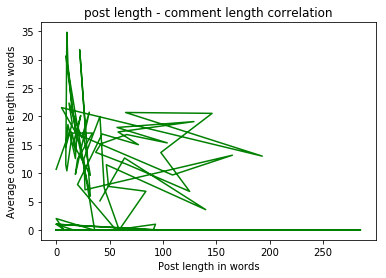

In [10]:
if __name__ == "__main__":
    (post, comment, post_length, first_name,
     last_name, sex, city, bdate, age, education) = get_post()
    comments_length = count_words_in_comments(comment)
    grafiki()